In [19]:
import geopandas as gpd
import pandas as pd
import os

In [20]:
buildings = gpd.read_parquet("./out/singapore/buildings.pq")
tessellation = gpd.read_parquet("./out/singapore/tessellation_stats.pq")

In [21]:
# Merge the two dataframes on their uID values, keeping the geometry of the left dataframe
tessellation_merged = pd.merge(tessellation, buildings[['uID']], on='uID', how='left')

# Convert the merged dataframe back into a geodataframe, using the geometry of the left dataframe
tessellation_merged = gpd.GeoDataFrame(tessellation_merged, crs=tessellation.crs, geometry=tessellation.geometry)



<Axes: >

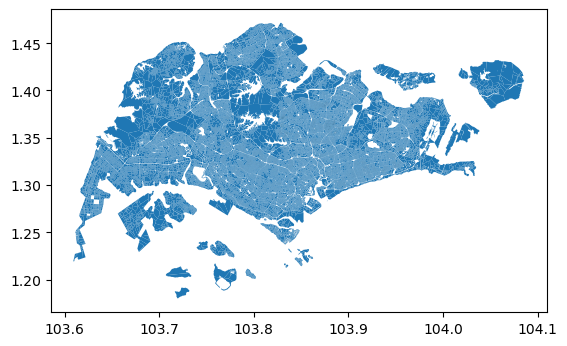

In [22]:
tessellation_merged.to_crs("EPSG:4326").plot()

In [23]:
directory = './out/singapore/final/'

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory if it doesn't exist
    os.makedirs(directory)

In [24]:
tessellation_merged.to_crs("epsg:4326").to_file('./out/singapore/final/tessellation.geojson', driver='GeoJSON')

In [25]:
buildings.set_crs(tessellation.crs).to_crs("epsg:4326").to_file('./out/singapore/final/buildings.geojson', driver='GeoJSON')

In [26]:
tessellation["uID"]

0        75707.0
1        74906.0
2        74909.0
3        74915.0
4        74921.0
          ...   
76493    74471.0
76494    75817.0
76495    75833.0
76496    75840.0
76497    75848.0
Name: uID, Length: 76498, dtype: float64

In [27]:
buildings

,geometry,uID,cluster
0,"POLYGON ((4098.105 23706.883, 4109.145 23706.8...",0,4.0
1,"POLYGON ((4169.087 23688.953, 4169.269 23731.3...",1,4.0
2,"POLYGON ((4129.786 23795.994, 4196.953 23795.9...",2,4.0
3,"POLYGON ((3940.171 23898.114, 3939.741 23952.6...",3,4.0
4,"POLYGON ((3908.968 23952.996, 3934.866 23953.1...",4,4.0
...,...,...,...
76528,"POLYGON ((48435.142 44390.888, 48430.958 44386...",76528,2.0
76529,"POLYGON ((55493.670 44419.941, 55504.409 44424...",76529,5.0
76530,"POLYGON ((49317.745 44483.611, 49307.007 44480...",76530,2.0
76531,"POLYGON ((52543.742 44651.786, 52541.350 44642...",76531,5.0
